# Plotting with Marsilea in Scanpy

[Marsilea](https://github.com/Marsilea-viz/marsilea) is a visualization library that allows user to create composable visualization in a declaritive way.

You can use it to create many scanpy plots with easy customization.

Let's first load the PBMC datdaset

In [1]:
%config InlineBackend.figure_format = "retina"
import scanpy as sc

pbmc = sc.datasets.pbmc3k_processed().raw.to_adata()

In [2]:
pbmc

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    obsp: 'distances', 'connectivities'

Define the cells and markers that we want to draw

In [3]:
cell_markers = {
    "CD4 T cells": ["IL7R"],
    "CD14+ Monocytes": ["CD14", "LYZ"],
    "B cells": ["MS4A1"],
    "CD8 T cells": ["CD8A"],
    "NK cells": ["GNLY", "NKG7"],
    "FCGR3A+ Monocytes": ["FCGR3A", "MS4A7"],
    "Dendritic cells": ["FCER1A", "CST3"],
    "Megakaryocytes": ["PPBP"],
}

markers, cells = [], []
for c, ms in cell_markers.items():
    markers += ms
    cells += [c] * len(ms)

uni_cells = list(cell_markers.keys())
cell_colors = [
    "#568564",
    "#FFF3A7",
    "#F72464",
    "#005585",
    "#9876DE",
    "#405559",
    "#58DADA",
    "#F85959",
]
cmapper = dict(zip(uni_cells, cell_colors))

Import Marsilea

In [4]:
import marsilea as ma
import marsilea.plotter as mp

# To install new font
import mpl_fontkit as fk

fk.install("Lato", verbose=False)

# Heatmap

In [5]:
exp = pbmc[:, markers].X.A

Here is the minimum example to create a heatmap with Marsilea, it does nothing besides create a heatmap. You can adjust the main plot size by setting `height` and `width`, the unit is inches.

We will start adding components to this main plot step by step.

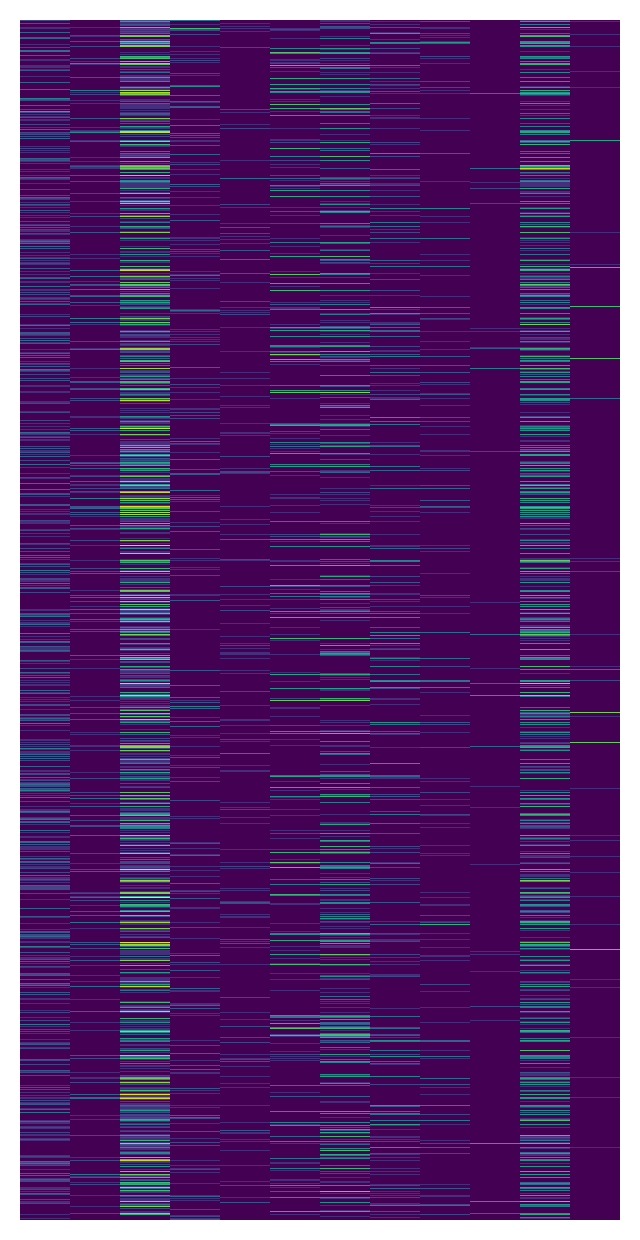

In [6]:
m = ma.Heatmap(exp, cmap="viridis", height=6, width=3)
m.render()

To replicate the scanpy heatmap, we can first divide the heatmap by cell types.

The `hsplit` stands for horizontal split, `labels` is used to label the row, the `order` define the display order of 
each cell types from top to bottom.

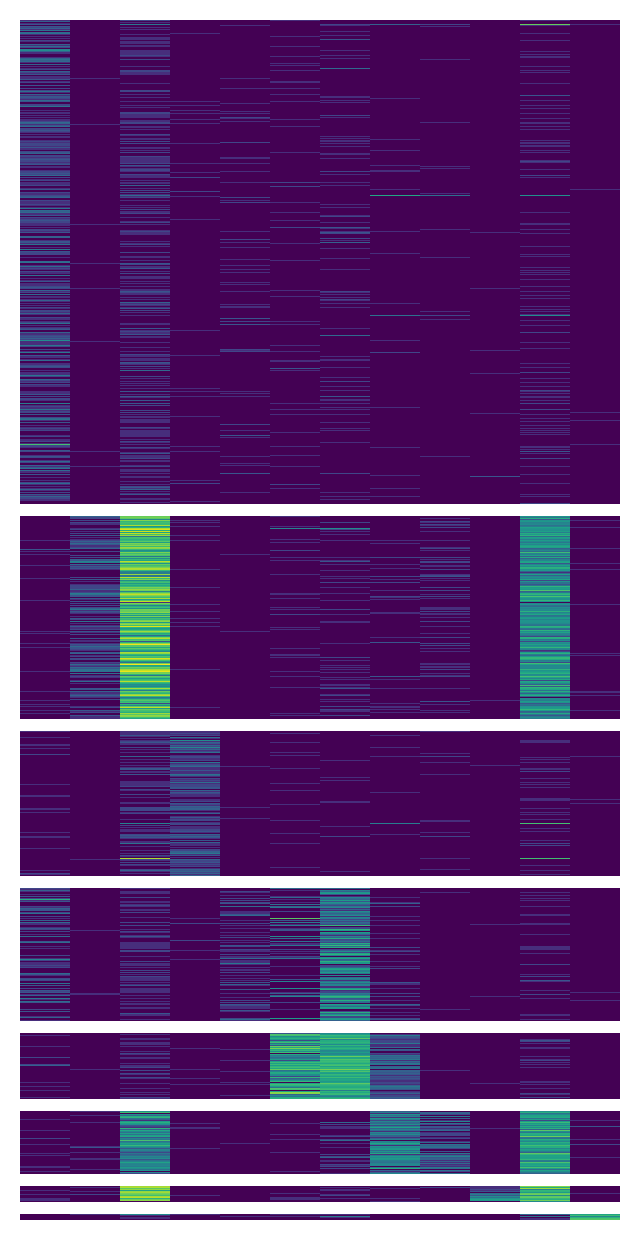

In [7]:
m.hsplit(labels=pbmc.obs["louvain"], order=uni_cells)
m.render()

Now we can label each chunks with cell types and the columns with marker names.

You can use `add_left` or `add_*` to add a plotter to anyside of your main plot. In Marsilea, a plot instance is called plotter. 

When you add a plotter, you can easily adjust its size and the padding between adjcent plot using `size` and `pad`.

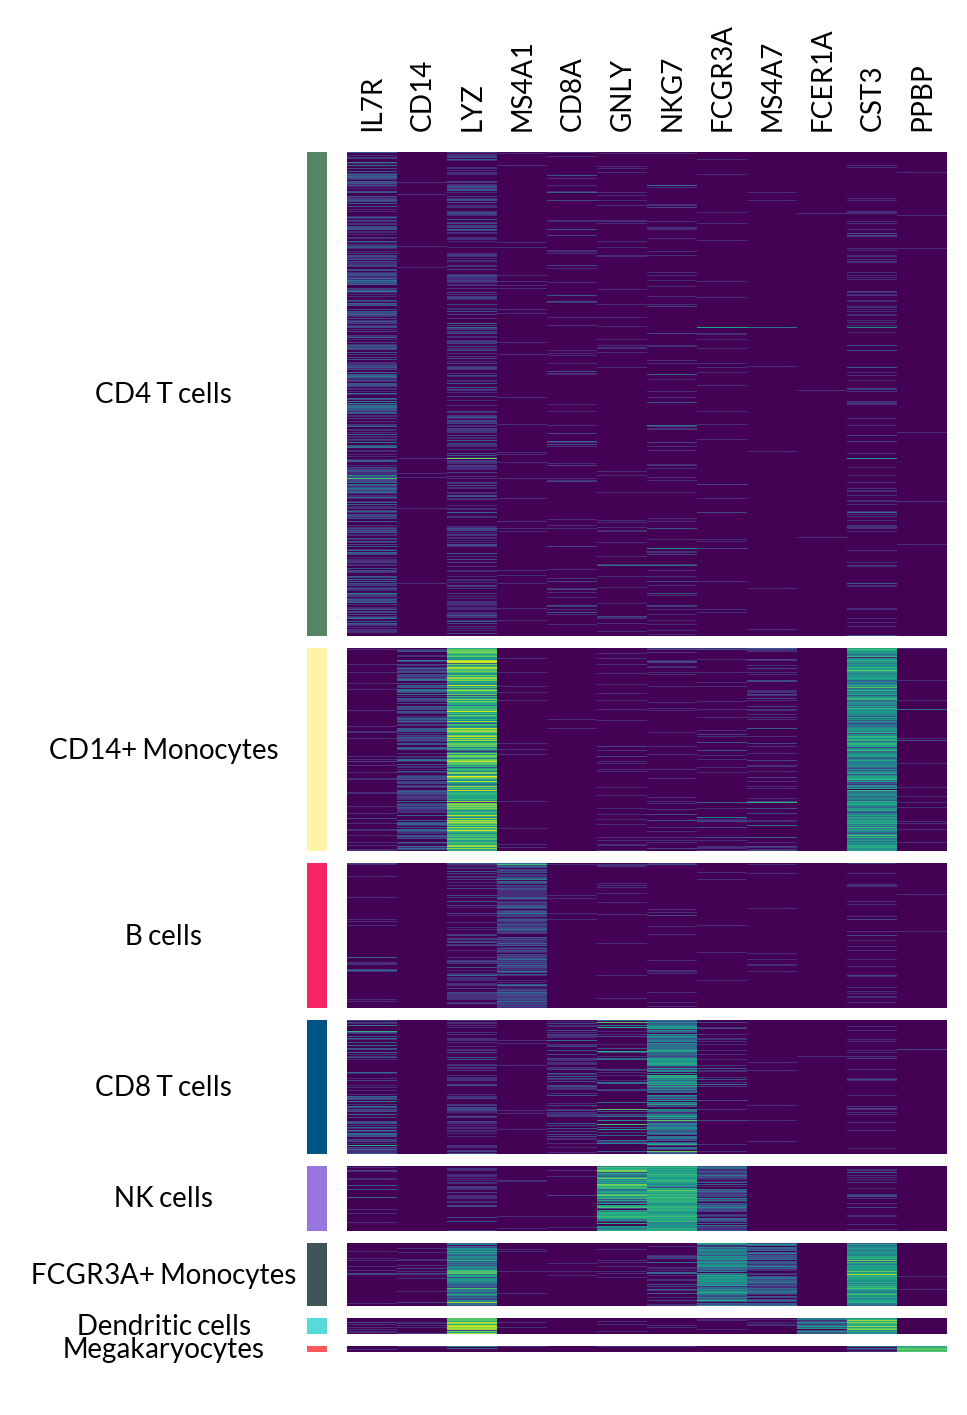

In [8]:
# Create plotters
chunk = mp.Chunk(uni_cells, rotation=0, align="center")
colors = mp.Colors(list(pbmc.obs["louvain"]), palette=cmapper)
label_markers = mp.Labels(markers)

# Add to the heatmap
m.add_left(colors, size=0.1, pad=0.1)
m.add_left(chunk)
m.add_top(label_markers, pad=0.1)
m.render()

You may want to add dendrogram to display the similarity among cell types.

You can use `add_dendrogram`, we will add it to the right side, but you can also add it to the left side if you want.

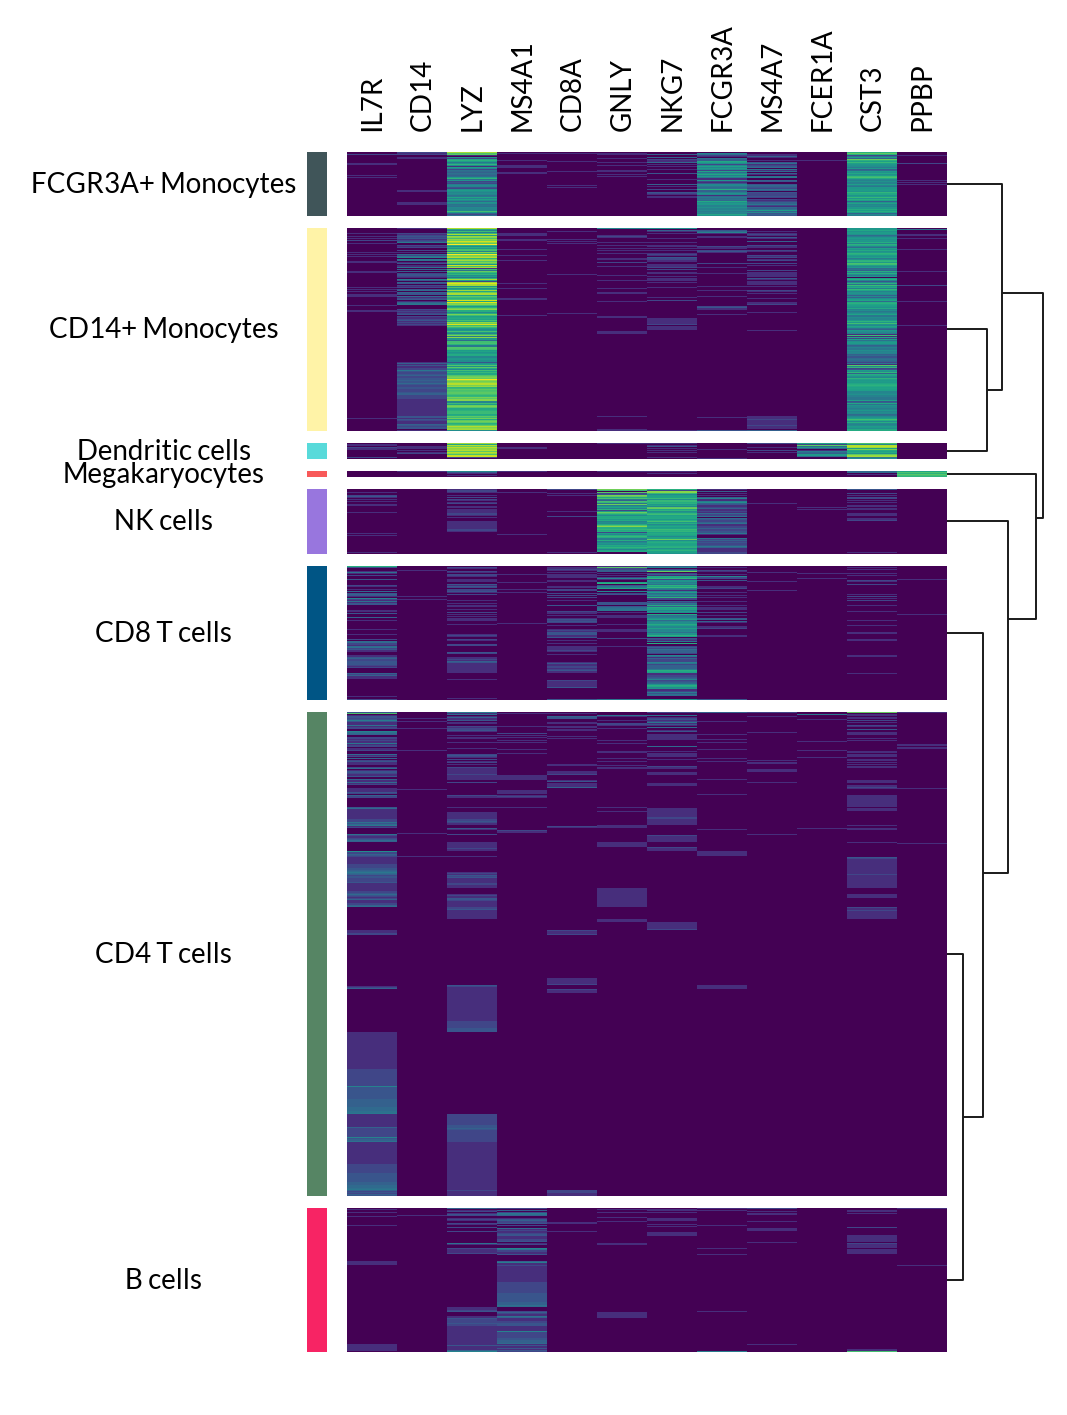

In [9]:
m.add_dendrogram("right", add_base=False)
m.render()

The legend is still mising, you can use `add_legends` to add all legends at once. Marsilea will automatically layout all the legends.

In the end, you can you `add_title` to add a title.

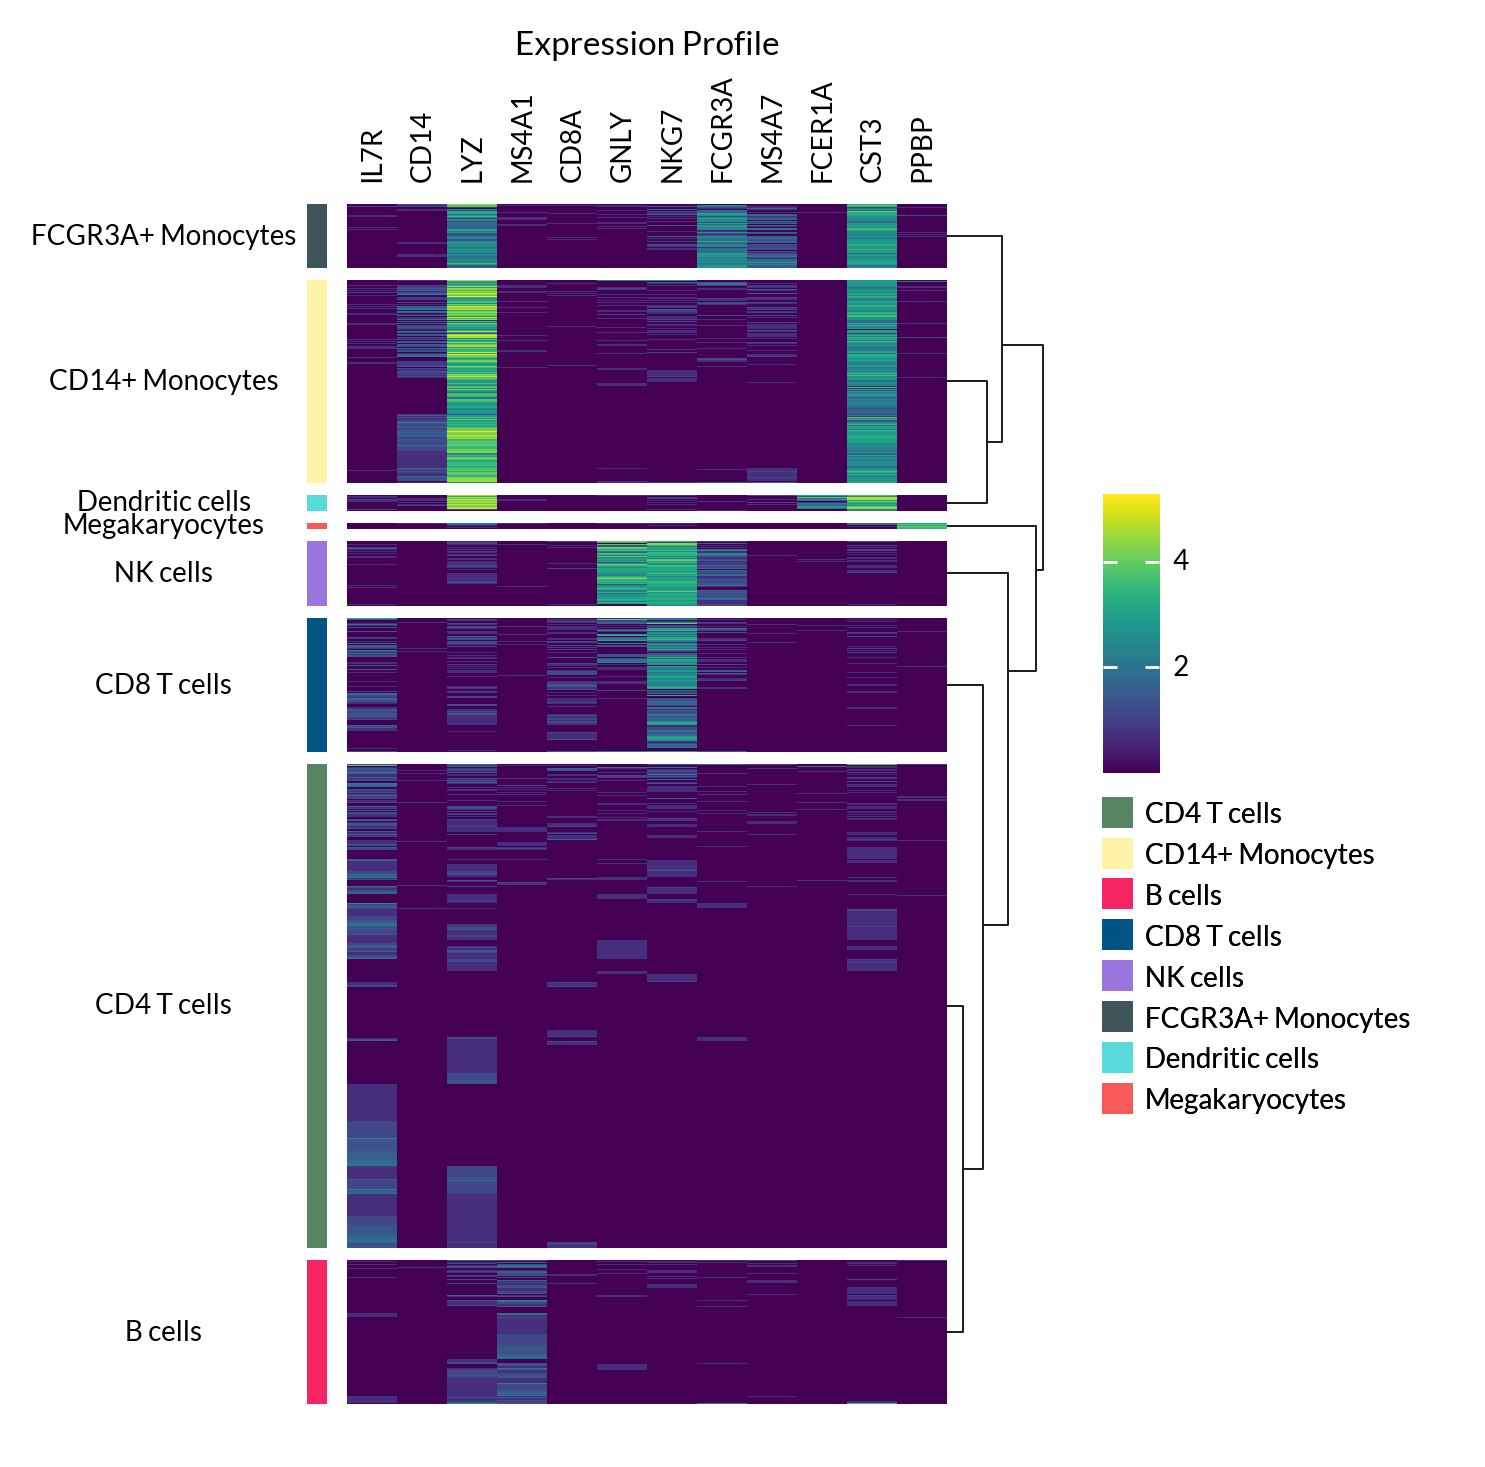

In [10]:
m.add_legends()
m.add_title("Expression Profile")
m.render()

OK, let's wrap up all the code in below. There are few things you should notice in Marsilea:

- Always call `render()` in the end to actually render the plot.
- The order of `add_*` operation decides the order of plotters. But `vsplit` and `hsplit` can be called anytime.

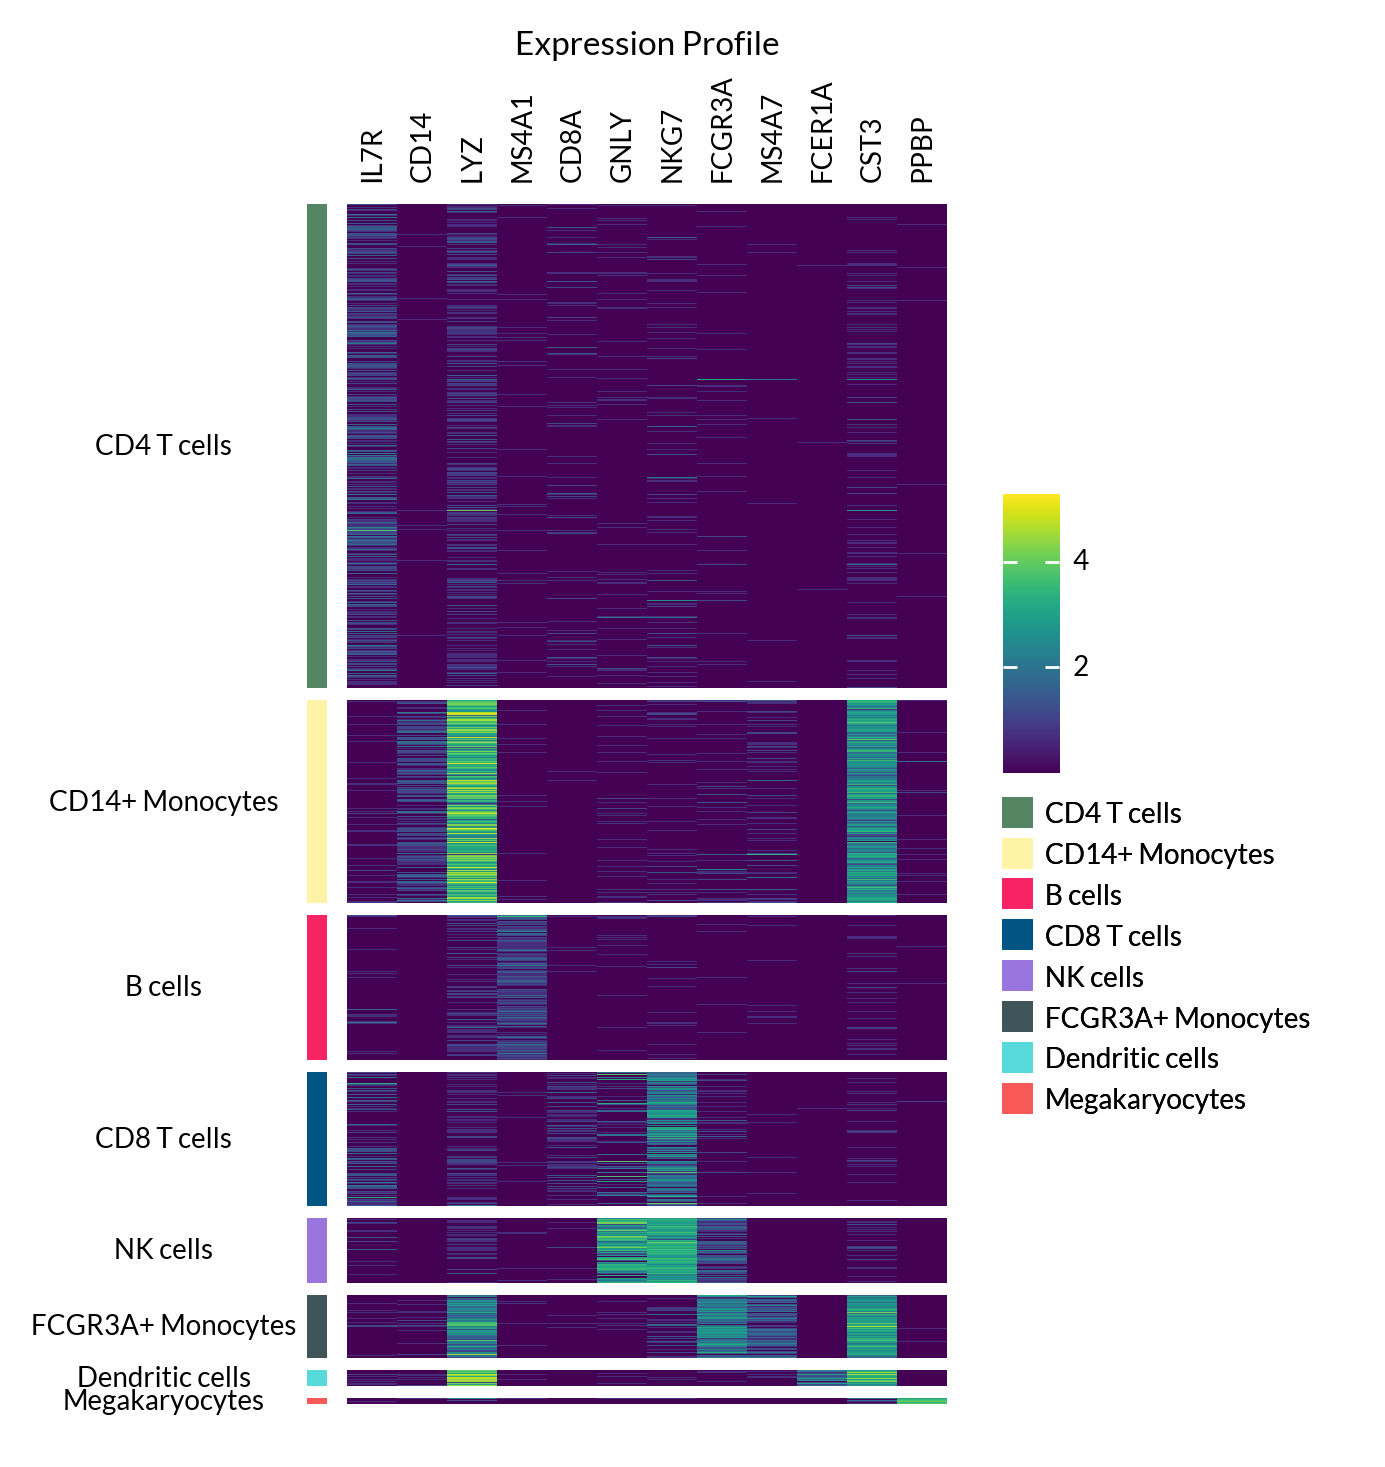

In [11]:
m = ma.Heatmap(exp, cmap="viridis", height=6, width=3)
m.hsplit(labels=pbmc.obs["louvain"], order=uni_cells)

chunk = mp.Chunk(uni_cells, rotation=0, align="center")
colors = mp.Colors(list(pbmc.obs["louvain"]), palette=cmapper)
label_markers = mp.Labels(markers)

m.add_left(colors, size=0.1, pad=0.1)
m.add_left(chunk)
m.add_top(label_markers, pad=0.1)

m.add_legends()
m.add_title("Expression Profile")
m.render()

For other scanpy plots, please read below.

In [12]:
agg_data = sc.get.aggregate(pbmc, by="louvain", func=["mean", "count_nonzero"])
agg_data

AnnData object with n_obs × n_vars = 8 × 13714
    obs: 'louvain'
    var: 'n_cells'
    layers: 'mean', 'count_nonzero'

In [13]:
exp = agg_data[:, markers].layers["mean"]
count = agg_data[:, markers].layers["count_nonzero"]
cell_counts = pbmc.obs["louvain"].value_counts()[agg_data.obs["louvain"]]

# Matrixplot

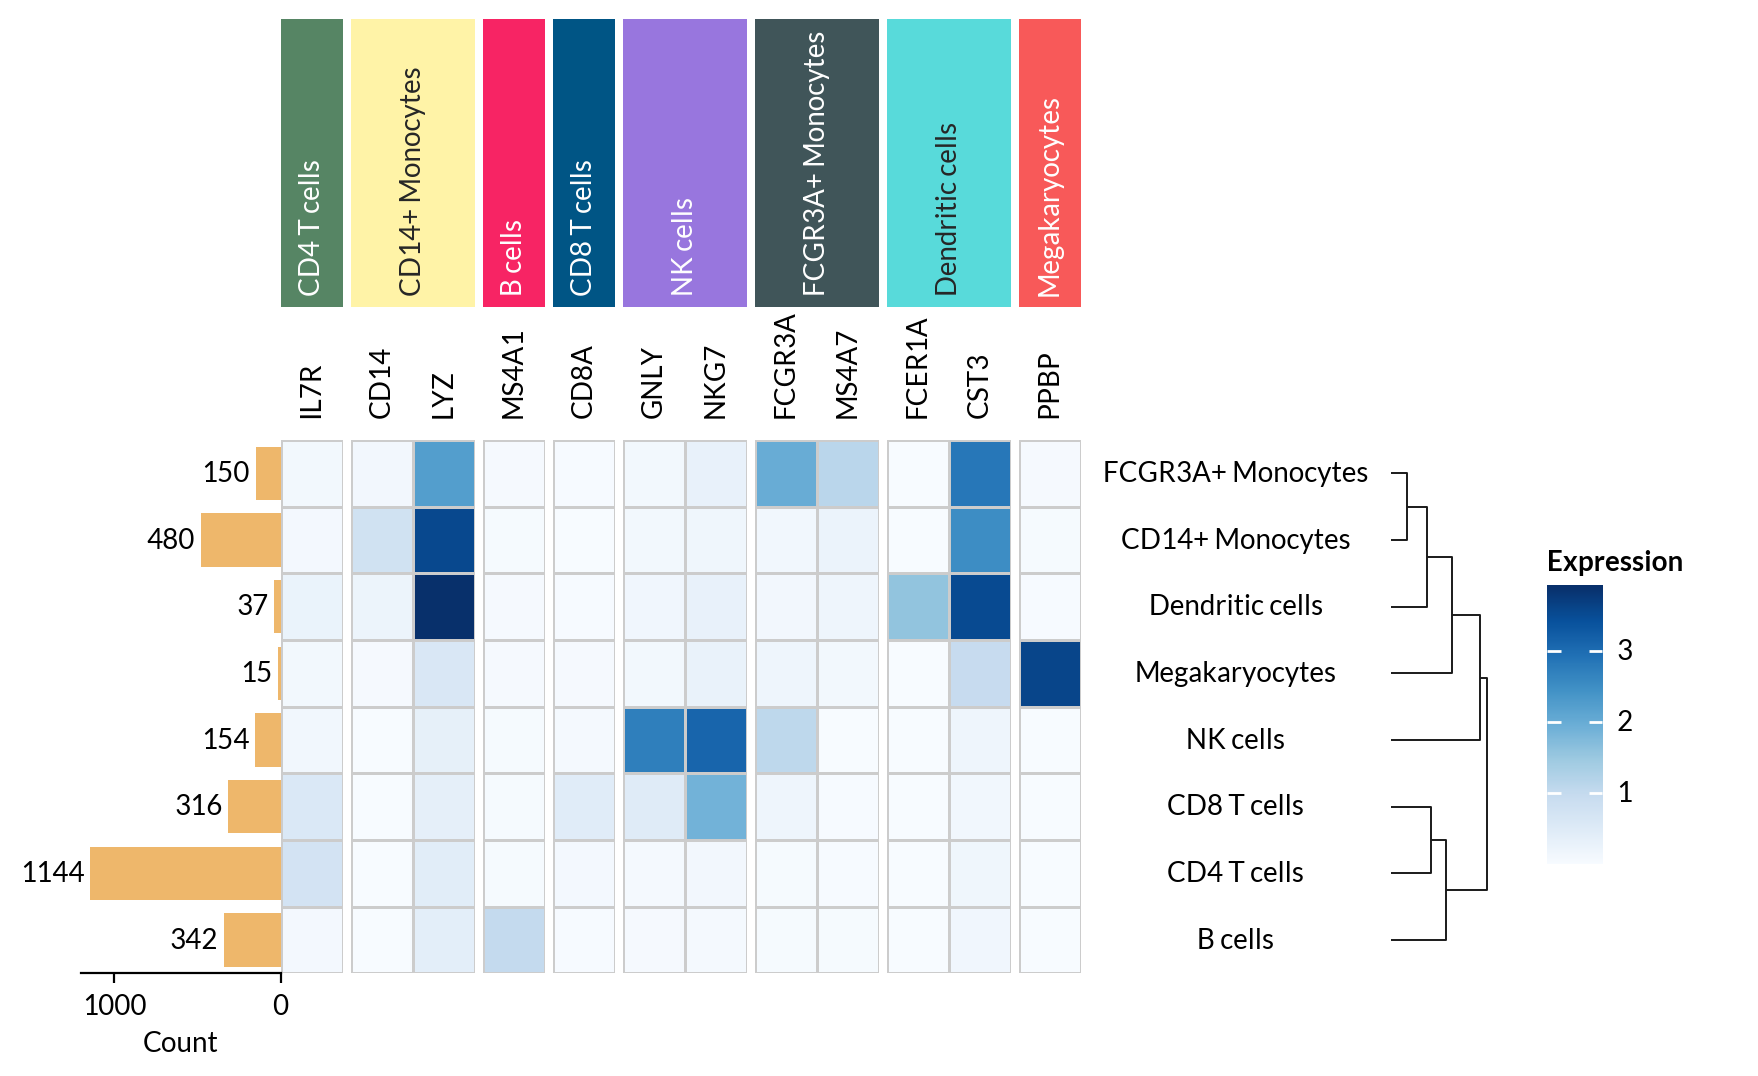

In [14]:
h, w = exp.shape
m = ma.Heatmap(
    exp,
    height=h / 3,
    width=w / 3,
    cmap="Blues",
    linewidth=0.5,
    linecolor=".8",
    label="Expression",
)
m.add_right(mp.Labels(agg_data.obs["louvain"], align="center"), pad=0.1)
m.add_top(mp.Labels(markers), pad=0.1)
m.vsplit(labels=cells, order=uni_cells)
m.add_top(mp.Chunk(uni_cells, fill_colors=cell_colors, rotation=90))
m.add_left(mp.Numbers(cell_counts, color="#EEB76B", label="Count"))
m.add_dendrogram("right", pad=0.1)
m.add_legends()
m.render()

# Dot plot

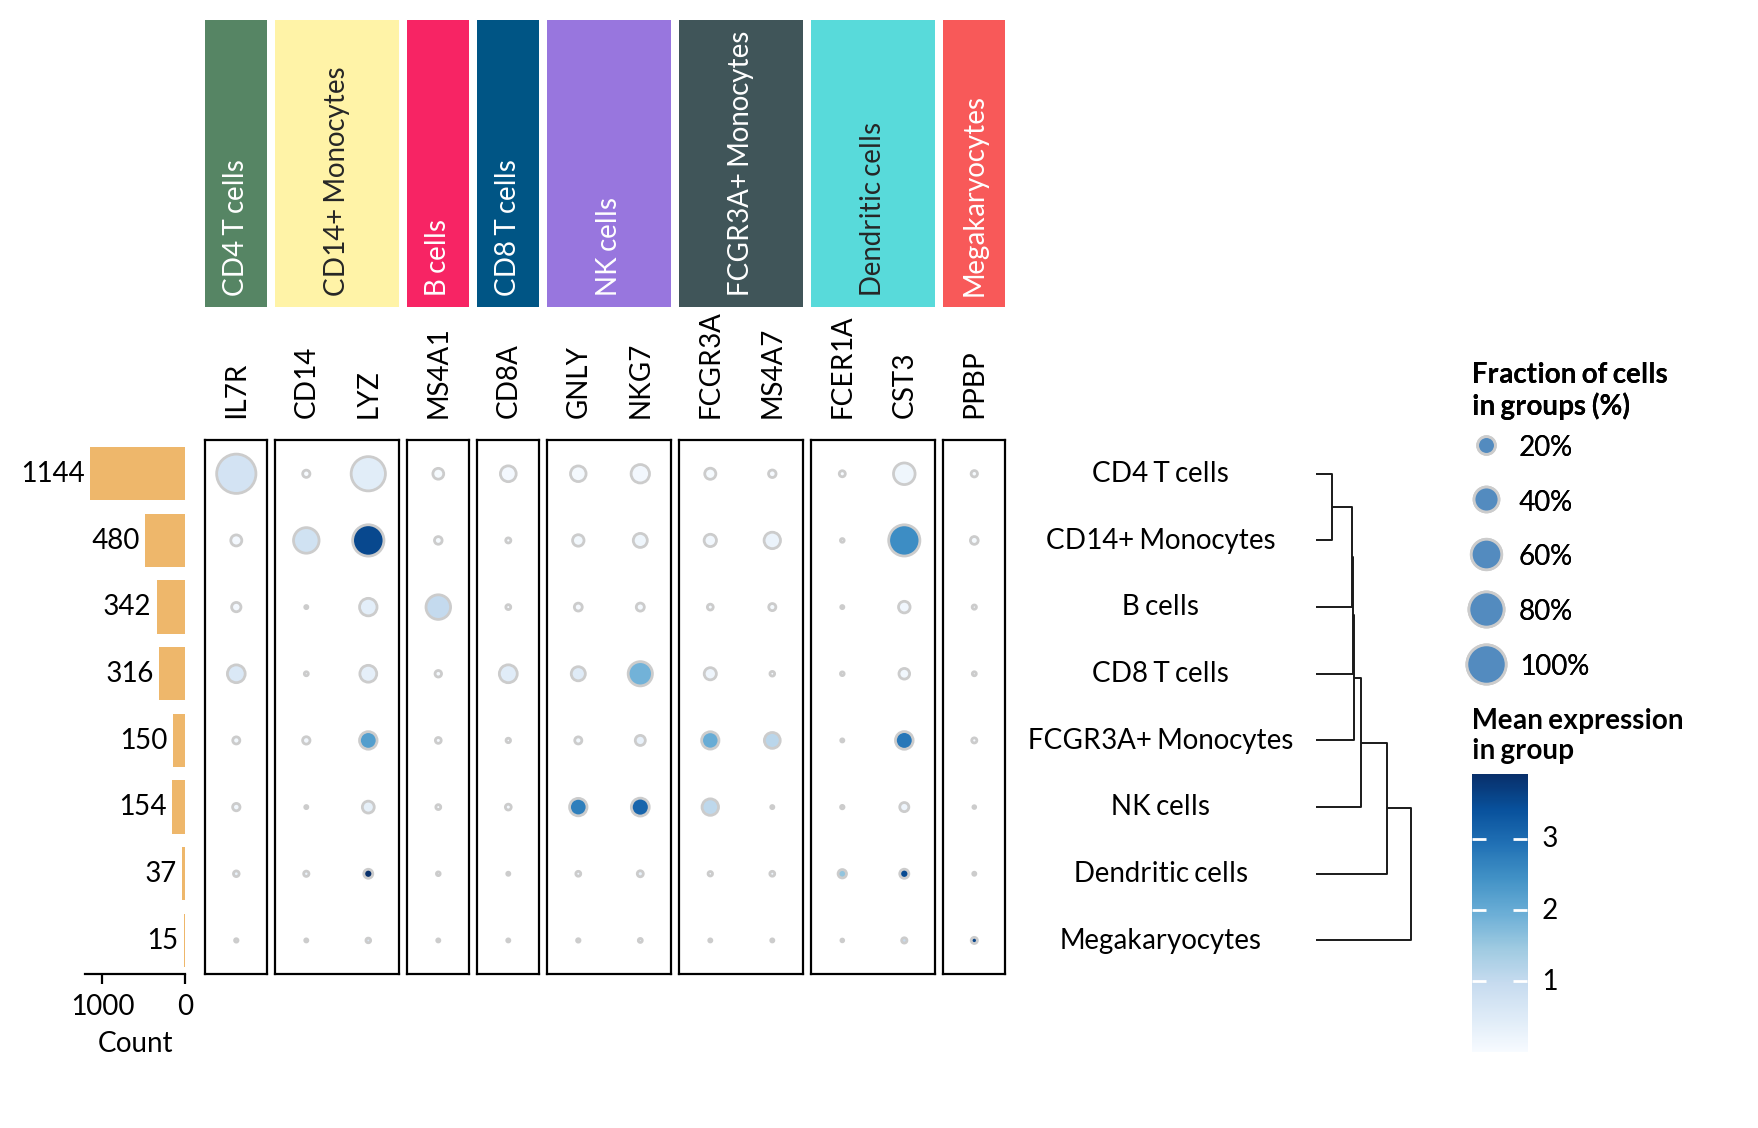

In [15]:
h, w = exp.shape
m = ma.SizedHeatmap(
    size=count,
    color=exp,
    cluster_data=count,
    height=h / 3,
    width=w / 3,
    edgecolor=".8",
    cmap="Blues",
    size_legend_kws=dict(
        colors="#538bbf",
        title="Fraction of cells\nin groups (%)",
        labels=["20%", "40%", "60%", "80%", "100%"],
        show_at=[0.2, 0.4, 0.6, 0.8, 1.0],
    ),
    color_legend_kws=dict(title="Mean expression\nin group"),
)
m.add_right(mp.Labels(agg_data.obs["louvain"], align="center"), pad=0.1)
m.add_top(mp.Labels(markers), pad=0.1)
m.vsplit(labels=cells, order=uni_cells)
m.add_top(mp.Chunk(uni_cells, fill_colors=cell_colors, rotation=90))
m.add_left(mp.Numbers(cell_counts, color="#EEB76B", label="Count"), size=0.5, pad=0.1)
m.add_dendrogram("right", pad=0.1)
m.add_legends()
m.render()

# Tracksplot and Stacked violin

These plots are also possible with Marsilea by creating new plotter.

[How to create new plotter in Marsilea](https://marsilea.readthedocs.io/en/latest/tutorial/new_renderplan.html)